# Intuit Quickbooks Upgrade
* Name:
* GitLab id:

## Setup

Please complete this python notebook with your group by answering the questions in `intuit.pdf` on Canvas (week6/). Create a Notebook/HTML file with all your results and comments and push both the Rmarkdown and HTML file to GitLab when your team is done. All results MUST be reproducible (i.e., the TA and I must be able to recreate the HTML from the Jupyter Notebook file without changes or errors). This means that you should NOT use any python-packages that are not part of the rsm-msba-spark docker container.

This is the first group assignment for MGTA 455 and you will be using git and GitLab. If two people edit the same file at the same time you could get what is called a "merge conflict". git will not decide for you who's change to accept so the team-lead will have to determine which edits to use. To avoid merge conflicts, **always** "pull" changes to the repo before you start working on any files. Then, when you are done, save and commit your changes, and then push them to GitLab. Make "pull first" a habit!

If multiple people are going to work on the assignment at the same time I recommend you work in different notebooks. You can then `%run ...`  these "sub" notebooks from the main assignment file. 

Group work-flow tips as discussed during ICT in Summer II are shown below:

* Pull, edit, save, stage, commit, and push
* Schedule who does what and when
* Try to avoid working simultaneously on the same file 
* If you are going to work simultaneously, do it in different notebooks, e.g., 
    - question1.ipynb, question2.ipynb, question3.ipynb
* Use the `%run ... ` command to bring different pieces of code together into the main jupyter notebook

A graphical depiction of the group work-flow is shown below:

![](../images/git-group-workflow.png)

Tutorial videos about using Git, GitLab, and GitGadget for group assignments:

* Setup the MSBA server to use Git and GitLab: https://youtu.be/oUrI7G3NHDg
* Dealing with Merge Conflicts: https://youtu.be/elq5UUG0RbE
* Group assignment practice: https://youtu.be/uwqUHl3z37o

Additional resources on git are linked below:

* http://happygitwithr.com
* http://r-pkgs.had.co.nz/git.html
* http://stackoverflow.com/questions/tagged/git or just a google search
* https://try.github.io
* https://www.manning.com/books/git-in-practice
* https://github.com/GitInPractice/GitInPractice#readme

In [1]:
import statsmodels.formula.api as smf
from pyrsm import describe, predict_conf_int
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from pyrsm import gains, gains_plot, lift, lift_plot, confusion, profit_max, ROME_max

In [2]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_pickle("../data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)
# adding a random number that should be dropped by lasso
intuit75k["rnd"] = np.random.randn(intuit75k.shape[0])
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes,rnd
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0,0.538965
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0,-0.904449
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0,0.021184
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0,-1.357422
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0,0.059564


In [3]:
rvar = "res1_yes"
evar = [
    "zip_bins",
    "numords",
    "dollars",
    "last",
    "version1",
    "owntaxprod",
    "upgraded"
]
idvar = "id"
lev = "yes"

# not required - just an example of how you would do this in python
intuit75k.drop(columns=["training"])
train, test = train_test_split(
    intuit75k, test_size=0.3, random_state=1234, stratify=intuit75k["res1_yes"]
)

# stratification insures the proportion of buyers is (almost) identical
train["res1_yes"].sum() / train.shape[0]
test["res1_yes"].sum() / test.shape[0]

# adding the (new) training variable to the dataset
train.loc[:, "training"] = 1
test.loc[:, "training"] = 0

# storing results for evaluation of different models
eval_dat = pd.concat([train, test], axis=0)
eval_dat = eval_dat[[idvar, rvar, "training"]]

X_train = train[evar]
y_train = train[rvar]
X_test = test[evar]
y_test = test[rvar]

# scaling the training data
scaler = StandardScaler()
scaler.fit(X_train)

# apply transformation to training data
Xs_train = scaler.transform(X_train)

# apply same transformation to test data
Xs_test = scaler.transform(X_test)

# combining so we can predict for the full dataset as well
Xs = np.concatenate((Xs_train, Xs_test), axis=0)

/Users/jasonxie/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [4]:
# Logistic regression with strong L1 regularization
clf = LogisticRegression(
    random_state=1234, max_iter=1000, solver="saga", penalty="l1", C=0.01
)

clf.fit(Xs_train, y_train)
coef = clf.fit(Xs_train, y_train).coef_
coef = pd.DataFrame({"labels": evar, "coefficients": coef[0], "OR": np.exp(coef[0])})

In [5]:
# Effect of the 'rnd' variable set to 0
coef.query("coefficients == 0")
lr_proba = clf.predict_proba(Xs)
eval_dat["y_lr"] = lr_proba[:, 1]

In [6]:
# Logistic regression with LASSO
clf = LogisticRegression(random_state=1234, max_iter=1000, solver="saga", penalty="l1")
param_grid = dict(
    C=[1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025], class_weight=["None"]
)
lr_lasso_search = GridSearchCV(clf, param_grid, cv=3, scoring="roc_auc")
lr_lasso_search.fit(Xs_train, y_train)

results = pd.DataFrame(lr_lasso_search.cv_results_)
results = results.sort_values(by=["rank_test_score"])
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.078177,0.000712,0.004649,0.000721,1,None,"{'C': 1, 'class_weight': 'None'}",0.696699,0.703581,0.711036,0.703772,0.005855,1
1,0.077626,0.000282,0.004084,0.000066,0.5,None,"{'C': 0.5, 'class_weight': 'None'}",0.696691,0.703560,0.711050,0.703767,0.005864,2
2,0.076728,0.000070,0.004029,0.000016,0.25,None,"{'C': 0.25, 'class_weight': 'None'}",0.696693,0.703526,0.711069,0.703763,0.005871,3
3,0.077544,0.002440,0.004103,0.000080,0.1,None,"{'C': 0.1, 'class_weight': 'None'}",0.696668,0.703427,0.711131,0.703742,0.005909,4
4,0.078373,0.004831,0.004278,0.000241,0.05,None,"{'C': 0.05, 'class_weight': 'None'}",0.696635,0.703249,0.711195,0.703693,0.005953,5
5,0.102965,0.004385,0.004987,0.000479,0.025,None,"{'C': 0.025, 'class_weight': 'None'}",0.696519,0.702797,0.711356,0.703557,0.006081,6
6,0.100269,0.005077,0.004911,0.000314,0.01,None,"{'C': 0.01, 'class_weight': 'None'}",0.695837,0.702323,0.711474,0.703211,0.006415,7
7,0.094486,0.009386,0.004894,0.000334,0.005,None,"{'C': 0.005, 'class_weight': 'None'}",0.692740,0.699890,0.710382,0.701004,0.007245,8
8,0.073499,0.001281,0.004242,0.000123,0.0025,None,"{'C': 0.0025, 'class_weight': 'None'}",0.657847,0.679937,0.687417,0.675067,0.012554,9


In [7]:
lr_lasso_best = LogisticRegression(
    random_state=1234,
    max_iter=1000,
    solver="saga",
    penalty="l1",
    C=results.loc[0, "param_C"],
    class_weight="None",
)

lr_lasso_best.fit(Xs_train, y_train)
lr_lasso_best.fit(Xs_train, y_train).intercept_
coef = lr_lasso_best.fit(Xs_train, y_train).coef_
pd.DataFrame({"labels": evar, "coefficients": coef[0], "OR": np.exp(coef[0])})

,labels,coefficients,OR
0,zip_bins,-0.288714,0.749226
1,numords,0.297213,1.346102
2,dollars,0.068701,1.071116
3,last,-0.386855,0.679189
4,version1,0.326554,1.386183
5,owntaxprod,0.044598,1.045607
6,upgraded,0.385145,1.469827


In [8]:
lasso_proba = lr_lasso_best.predict_proba(Xs)
eval_dat["y_lasso"] = lasso_proba[:, 1]

# Neural net from SKLEARN
clf = MLPClassifier(
    solver="adam",
    learning_rate_init=0.01,
    alpha=0.01,
    hidden_layer_sizes=(2, 2),
    random_state=1234,
    max_iter=1000,
)
clf.fit(Xs_train, y_train)
nn_proba = clf.predict_proba(Xs)
eval_dat["y_nn"] = nn_proba[:, 1]
eval_dat

,id,res1_yes,training,y_lr,y_lasso,y_nn
71492,71493,0,1,0.043903,0.040071,0.041483
21077,21078,0,1,0.031172,0.029307,0.026019
25057,25058,0,1,0.027607,0.024264,0.025774
30693,30694,0,1,0.033808,0.032225,0.029407
37069,37070,0,1,0.111275,0.115430,0.096360
...,...,...,...,...,...,...
17828,17829,0,0,0.094351,0.099979,0.086122
60454,60455,1,0,0.036123,0.033365,0.029651
29283,29284,0,0,0.054016,0.048494,0.040307
45869,45870,0,0,0.011984,0.009487,0.010810


In [9]:
# CV for NN
nr_hnodes = range(4, 6)
hls = (
    list(zip(nr_hnodes))
    + list(zip(nr_hnodes, nr_hnodes))
    + list(zip(nr_hnodes, nr_hnodes, nr_hnodes))
)
hls

[(4,), (5,), (4, 4), (5, 5), (4, 4, 4), (5, 5, 5)]

In [10]:
param_grid = {"hidden_layer_sizes": hls, "alpha": [0.001, 0.01, 0.05]}
scoring = {"AUC": "roc_auc"}

clf_cv = GridSearchCV(
    clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
)
clf_cv.fit(Xs_train, y_train)

clf_cv.best_params_
clf_cv.best_score_
results = pd.DataFrame(clf_cv.cv_results_)
results = results.sort_values(by=["rank_test_AUC"])
results

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   10.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  1.6min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
4,3.931442,0.443178,0.004865,0.000170,0.001,"(4, 4, 4)","{'alpha': 0.001, 'hidden_layer_sizes': (4, 4, 4)}",0.769701,0.740577,0.756781,0.749163,0.762906,0.755826,0.010203,1
10,3.850967,0.751271,0.004813,0.000044,0.01,"(4, 4, 4)","{'alpha': 0.01, 'hidden_layer_sizes': (4, 4, 4)}",0.766130,0.739874,0.755945,0.747326,0.761938,0.754243,0.009568,2
16,3.496152,0.811237,0.004766,0.000130,0.05,"(4, 4, 4)","{'alpha': 0.05, 'hidden_layer_sizes': (4, 4, 4)}",0.767589,0.741159,0.744256,0.746580,0.759835,0.751884,0.010112,3
12,2.444257,0.620183,0.004187,0.000048,0.05,"(4,)","{'alpha': 0.05, 'hidden_layer_sizes': (4,)}",0.768130,0.736277,0.750704,0.747397,0.754619,0.751425,0.010349,4
3,6.558609,0.849385,0.004725,0.000143,0.001,"(5, 5)","{'alpha': 0.001, 'hidden_layer_sizes': (5, 5)}",0.768281,0.735362,0.723628,0.755656,0.752797,0.747145,0.015767,5
0,2.424574,0.580668,0.005137,0.000963,0.001,"(4,)","{'alpha': 0.001, 'hidden_layer_sizes': (4,)}",0.765870,0.706349,0.752046,0.748087,0.756157,0.745702,0.020546,6
1,3.777652,0.173778,0.004211,0.000160,0.001,"(5,)","{'alpha': 0.001, 'hidden_layer_sizes': (5,)}",0.753414,0.724949,0.744859,0.747244,0.747503,0.743594,0.009739,7
7,3.862379,0.487771,0.004177,0.000029,0.01,"(5,)","{'alpha': 0.01, 'hidden_layer_sizes': (5,)}",0.765487,0.717413,0.743727,0.746352,0.744827,0.743561,0.015322,8
6,2.431443,0.766435,0.004236,0.000265,0.01,"(4,)","{'alpha': 0.01, 'hidden_layer_sizes': (4,)}",0.768335,0.705812,0.735158,0.747228,0.754907,0.742288,0.021182,9
17,5.474431,0.928594,0.004718,0.000274,0.05,"(5, 5, 5)","{'alpha': 0.05, 'hidden_layer_sizes': (5, 5, 5)}",0.743456,0.721623,0.740297,0.750027,0.751958,0.741472,0.010793,10


In [11]:
nn_proba = clf_cv.best_estimator_.predict_proba(Xs)
eval_dat["y_nn_cv"] = nn_proba[:, 1]
eval_dat

,id,res1_yes,training,y_lr,y_lasso,y_nn,y_nn_cv
71492,71493,0,1,0.043903,0.040071,0.041483,0.016794
21077,21078,0,1,0.031172,0.029307,0.026019,0.025632
25057,25058,0,1,0.027607,0.024264,0.025774,0.012192
30693,30694,0,1,0.033808,0.032225,0.029407,0.029534
37069,37070,0,1,0.111275,0.115430,0.096360,0.226412
...,...,...,...,...,...,...,...
17828,17829,0,0,0.094351,0.099979,0.086122,0.049523
60454,60455,1,0,0.036123,0.033365,0.029651,0.023435
29283,29284,0,0,0.054016,0.048494,0.040307,0.048018
45869,45870,0,0,0.011984,0.009487,0.010810,0.004640


In [12]:
# prediction on training set
pred = clf_cv.predict_proba(Xs_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train.values, pred[:, 1])
auc_rf = metrics.auc(fpr, tpr)
auc_rf

0.7593230529293544

In [13]:
# prediction on test set
pred = clf_cv.predict_proba(Xs_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, pred[:, 1])
auc_rf = metrics.auc(fpr, tpr)
auc_rf

0.7551179237126949

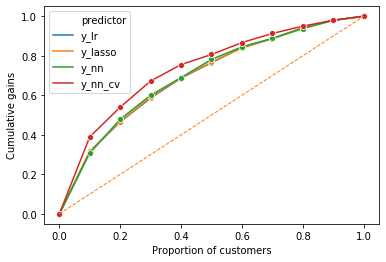

In [14]:
# performance evaluations
gains(eval_dat.query("training == 0"), "res1_yes", 1, "y_lr", qnt=10)
gains(eval_dat.query("training == 0"), "res1_yes", 1, "y_lasso", qnt=10)
gains_plot(
    eval_dat.query("training == 0"),
    "res1_yes",
    1,
    ["y_lr", "y_lasso", "y_nn", "y_nn", "y_nn_cv"],
    qnt=10,
)

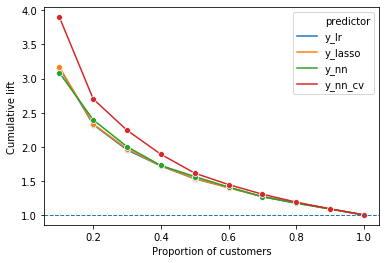

In [17]:
lift(eval_dat.query("training == 0"), "res1_yes", 1, "y_lr", qnt=10)
lift(eval_dat.query("training == 0"), "res1_yes", 1, "y_lasso", qnt=10)
lift_plot(
    eval_dat.query("training == 0"),
    "res1_yes",
    1,
    ["y_lr", "y_lasso", "y_nn", "y_nn", "y_nn_cv"],
    qnt=10,
)

In [15]:
profit_max(eval_dat.query("training == 0"), "res1_yes", 1, "y_lr", cost=1.41, margin=60)
profit_max(
    eval_dat.query("training == 0"), "res1_yes", 1, "y_nn_cv", cost=1.41, margin=60
)

36340.71000000001

In [19]:
ROME_max(eval_dat.query("training == 0"), "res1_yes", 1, "y_lr", cost=0.5, margin=6)

0.6463932107496464

In [21]:
ROME_max(eval_dat.query("training == 0"), "res1_yes", 1, "y_nn_cv", cost=0.5, margin=6)

0.9143222506393862